<h3 style="color:#edf1f7;font-size:50px;font-family:'Comic Sans MS';text-align:center;background-color : #4F0E0E; border-
radius: 5px 5px;"><strong>Customer Segmentation using RFM Analysis & K-Means Clustering</strong></h3>

<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Table of Content</strong></h3>

* [1. Importing Libraries](#1)


* [2. Loading Data](#2)


* [3. Data Preparation and Preprocessing](#3)


* [4. RFM Metrics](#4)


* [5. RFM Score](#5)


* [6. Segmenting customers using RFM score.](#6)


* [7. Interpretation of Descriptive Statistics of Segments](#7)


* [8. Some Comments on RFM segments](#8)



* [9. RFM Segmentation Visualization](#9)



* [10. Standardization](#10)


* [11. K-Means Segmentation](#11)

    * [10.1. Optimal numbers of clusters](#11.1)
    
    * [10.2. Training KMeans Algorithm](#11.2)
    
    * [10.3. Which Cluster Is Our Best Customers](#11.3)
 
        


# **Business Problem**
## **Description**
As a manager of the online store, you would want to group the customers into different clusters, so that you can make a customised marketing campaign for each of the group. You would have to decide what the important business criteria are on which you would want to segregate the customers. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## **Task**
- Decide the important business criteria to segregate he customers
- Group customers into clusters to run targeted campaigns

<a id="1"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Importing Libraries</strong></h3>

In [41]:
#Import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Uyarılar
warnings.filterwarnings("ignore")
import squarify
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

<a id="2"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Loading Data</strong></h3>

In [2]:
df= pd.read_csv('data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<a id="3"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Data Preparation and Preprocessing</strong></h3>

In [3]:
# The shape of the data 
print('This DataFrame has', df.shape[0] , 'Rows and ', df.shape[1], 'Columns')

This DataFrame has 541909 Rows and  8 Columns


In [4]:
# Dtype of each Feature
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
# see some statisticals of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [7]:
# check for NAN values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
#Remove the missing observations from the dataset
df.dropna(inplace=True)

In [9]:
#How many unique items in the dataset?
df["Description"].nunique()

3896

In [10]:
#Rank the 5 most ordered products from most to least
df.groupby('Description').agg({'Quantity':'sum'}).sort_values('Quantity', ascending = False).head(5)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53215
JUMBO BAG RED RETROSPOT,45066
ASSORTED COLOUR BIRD ORNAMENT,35314
WHITE HANGING HEART T-LIGHT HOLDER,34147
PACK OF 72 RETROSPOT CAKE CASES,33409


In [11]:
#Remove the canceled transactions from the dataset
df = df[~df["InvoiceNo"].str.contains("C", na=False)]

In [12]:
#The total amount of each invoice and we create that column just multiply 'Price' and 'Quantity'
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

<a id="4"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Creating RFM Metrics</strong></h3>

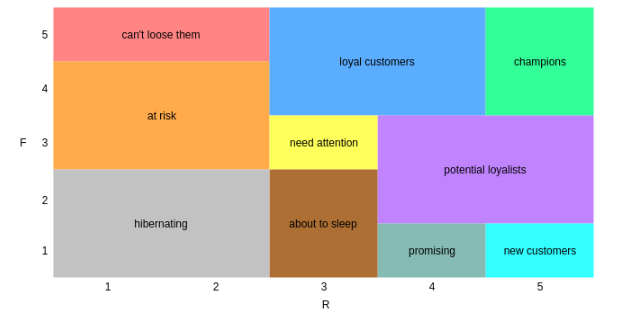

The Recency and Frequency Grid breaks your user base down into:
- Champions [R(4 – 5), F(4 – 5)]
- Loyal Customers [R(3 – 4), F(4 – 5)]
- Potential Loyalists [R(4 – 5), F(2 – 3)]
- Promising [R(3 – 4), F(0 – 1)]
- Can’t Lose Them [R(1 – 2), F(4 – 5)]
- At Risk [R(1 – 2), F(3 – 4)]
- About to Sleep [R(2 – 3), F(1-2)]
- Hibernating [R(1 – 2), F(1 – 2)]
- New Customers R [(4 – 5), F(0 – 1)]
- Need Attention R [(2 – 3), F(2 – 3)]

**Recency** - Time since last order or engaged with product.

**Frequency** - Total number of transactions made by customer or average time between transactions.

**Monetary** - Total or average amount spent by the customer.

In [13]:
#Determining the analysis date for the recency 
df['InvoiceDate'].max()
today_date = dt.datetime(2011, 12, 11)

rfm_analysis = df.groupby('CustomerID').agg({'InvoiceDate': lambda date:(today_date - date.max()).days,
                                   'InvoiceNo': lambda num : num.nunique(),
                                    'TotalPrice' : lambda totalprice : totalprice.sum()})
rfm_analysis.columns=['Recency', 'Frequency', 'Monetary']
rfm_analysis = rfm_analysis[rfm_analysis['Monetary'] > 0]
rfm_analysis.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


<a id="5"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Creating RFM Score</strong></h3>

In [14]:
#Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
rfm_analysis["recency_score"] = pd.qcut(rfm_analysis['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
rfm_analysis["frequency_score"] = pd.qcut(rfm_analysis["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#Total spend by the customer.The least money gets 1, the most money gets 5.
rfm_analysis["monetary_score"]= pd.qcut(rfm_analysis["Monetary"],5,labels=[1,2,3,4,5])

rfm_analysis.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,3,7,4310.00,5,5,5
12348.0,76,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,311,1,334.40,1,1,2


In [15]:
# If we concatenate R and F scores we will simply get RFM score  
rfm_analysis['RFM_SCORE'] = (rfm_analysis['recency_score'].astype('str') + rfm_analysis['frequency_score'].astype('str'))
rfm_analysis.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,311,1,334.40,1,1,2,11


<a id="6"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Segmenting customers using RFM score.</strong></h3>

In [16]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm_analysis['segment'] = rfm_analysis['RFM_SCORE'].replace(seg_map, regex=True)
rfm_analysis.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1797.24,2,4,4,24,at_Risk
12349.0,19,1,1757.55,4,1,4,41,promising
12350.0,311,1,334.40,1,1,2,11,hibernating


<a id="7"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Interpretation of Descriptive Statistics of Segments
</strong></h3>

In [21]:
rfm_stat = rfm_analysis[["segment", "Recency", "Frequency","Monetary"]].groupby('segment').agg(['mean','count','max']).round()
rfm_stat

Recency            Frequency            Monetary        \
                       mean count  max      mean count  max     mean count   
segment                                                                      
about_to_sleep         53.0   352   72       1.0   352    2    472.0   352   
at_Risk               154.0   593  374       3.0   593    6   1085.0   593   
cant_loose            133.0    63  373       8.0    63   34   2796.0    63   
champions               6.0   633   13      12.0   633  210   6858.0   633   
hibernating           218.0  1071  374       1.0  1071    2    489.0  1071   
loyal_customers        34.0   819   72       6.0   819   63   2864.0   819   
need_attention         52.0   187   72       2.0   187    3    898.0   187   
new_customers           7.0    42   13       1.0    42    1    388.0    42   
potential_loyalists    17.0   484   33       2.0   484    3   1041.0   484   
promising              24.0    94   33       1.0    94    1    294.0    94   

                               
                          max  
segment                        
about_to_sleep         6208.0  
at_Risk               44534.0  
cant_loose            10254.0  
champions            280206.0  
hibernating           77184.0  
loyal_customers      124915.0  
need_attention        12602.0  
new_customers          3861.0  
potential_loyalists  168472.0  
promising              1758.0

<a id="8"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Some Comments on RFM segments</strong></h3>


**Cant Loose**:

* There are `63 Customers` in this segment.
* The last time they made purchases was `133 days ago`.
* The average Frequency of shopping is `8`, and the total number of purchases is `34`.
* The average spent in this segment is `$2,796`.

**Action**:
We have to win them back, make them special offers and make them feel valuable. Also we can conduct a survey for that group for investigating why they are not present for a long time, it's abnormal because their frequency is the most among all customers.

**Need Attention**:

* There are `187` Customers in this segment.
* The last time they made purchases was `52 days ago`.
* The average Frequency of shopping is `2`, and the total number of purchases is `3`.
* The average spent in this segment is `$898`.

**Action**:
These customers need to be reminded of the brand.So, short-term discounts can be made to remind these customers of our brand and allow them to shop again.


**New Customers**:

* There are `42` Customers in this segment.
* The last time they made purchases was `7 days ago`.
* The average Frequency of shopping is `1`, and the total number of purchases is `1`.
* The average spent in this segment is `$388`.

**Action**:
They just visited our site, so We can offer them some special 'Welcome' offers.

<a id="9"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>RFM Segmentation Visualization
</strong></h3>

In [24]:
# value counts each segment
rfm_analysis["segment"].value_counts()

hibernating            1071
loyal_customers         819
champions               633
at_Risk                 593
potential_loyalists     484
about_to_sleep          352
need_attention          187
promising                94
cant_loose               63
new_customers            42
Name: segment, dtype: int64

In [25]:
# Calculate average values for each rfm_analysis, and return a size of each segment 
rfm_level_agg = rfm_analysis.groupby('segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                    Recency Frequency Monetary      
                       mean      mean     mean count
segment                                             
about_to_sleep         53.3       1.2    472.0   352
at_Risk               153.8       2.9   1084.5   593
cant_loose            133.0       8.4   2796.2    63
champions               6.4      12.4   6857.9   633
hibernating           217.6       1.1    488.6  1071
loyal_customers        33.6       6.5   2864.2   819
need_attention         52.4       2.3    897.6   187
new_customers           7.4       1.0    388.2    42
potential_loyalists    17.4       2.0   1041.2   484
promising              23.5       1.0    294.0    94


In [26]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

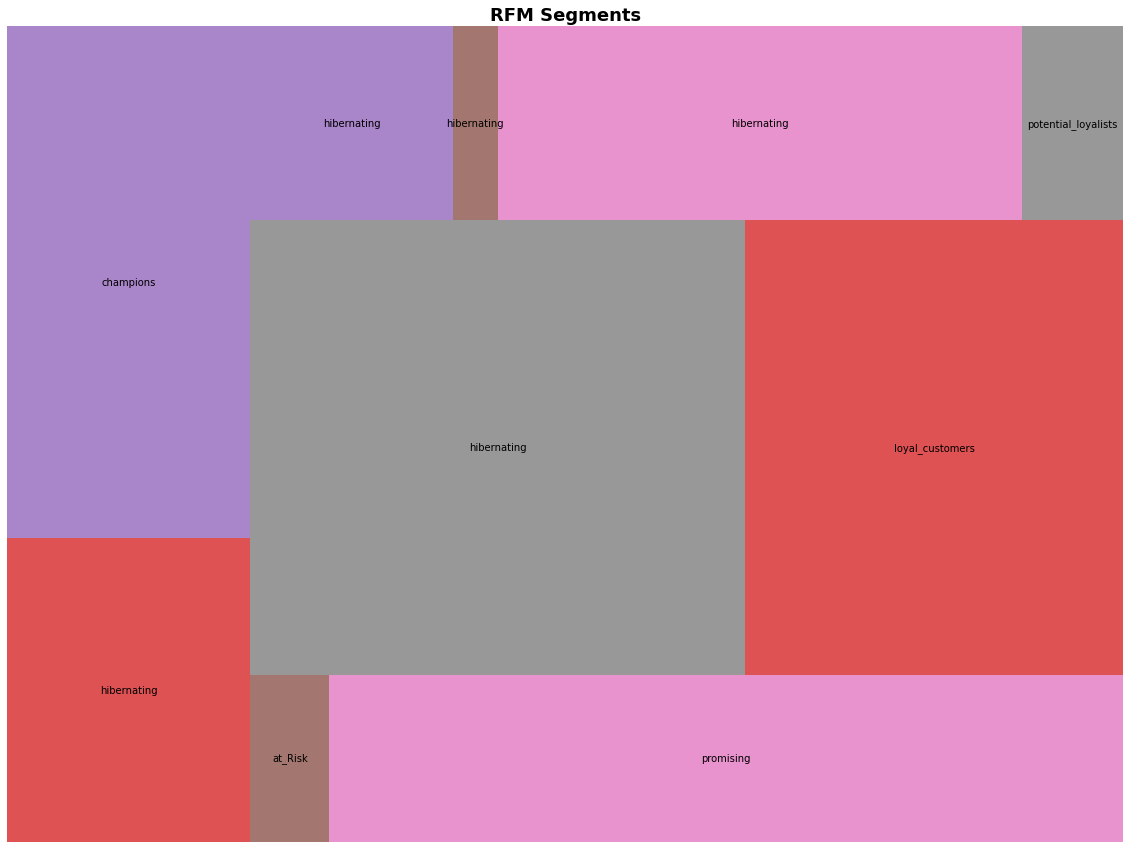

In [30]:
fig, ax = plt.subplots(1, figsize = (20,15))

squarify.plot(sizes = rfm_level_agg['Count'], 
              label=rfm_analysis['segment'], 
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<a id="10"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>Standardization
</strong></h3>

> `Standardization` is the process of rescaling the values of the variables in your data set so they share a common scale.

In [33]:
# making new data
rfm_clustering = rfm_analysis[['Recency','Frequency','Monetary']].copy()
rfm_clustering.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [36]:
min_max_scaler = MinMaxScaler()
scaler = min_max_scaler.fit_transform(rfm_clustering)
data_scaler2 = pd.DataFrame(scaler)

In [37]:
data_scaler2.head()

,0,1,2
0,0.871314,0.000000,0.275443
1,0.005362,0.028708,0.015368
2,0.201072,0.014354,0.006401
3,0.048257,0.000000,0.006259
4,0.831099,0.000000,0.001180


<a id="11"></a>
<h3 style="color:#4F0E0E;font-size:44px;font-family:newtimeroman;text-align:center;"><strong>K-Means Segmentation
</strong></h3>

<a id="11.1"></a>
<h3 style="color:#4F0E0E;font-size:35px;font-family:newtimeroman;text-align:center;"><strong>Identifying Optimal numbers of clusters
</strong></h3>

In [38]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',  random_state = 42)
    kmeans.fit(data_scaler2)
    wcss.append(kmeans.inertia_)

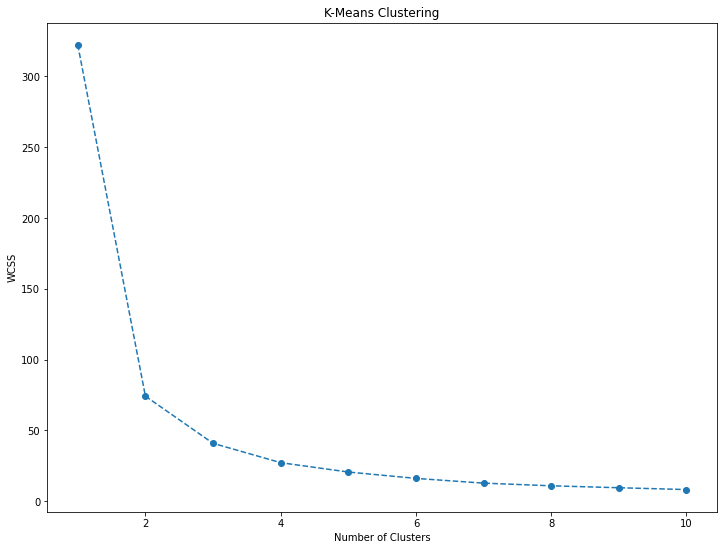

In [39]:
plt.figure(figsize = (12,9))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Clustering')
plt.show()

### `4` is the optimal number of clusters.

<a id="11.2"></a>
<h3 style="color:#4F0E0E;font-size:35px;font-family:newtimeroman;text-align:center;"><strong>Training KMeans Algorithm</strong></h3>

In [43]:
model = KMeans(n_clusters = 4)
model.fit(data_scaler2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
rfm_new = rfm_analysis[['Recency','Frequency','Monetary']]

label = model.labels_

d_frame = pd.DataFrame(rfm_new)
d_frame['cluster'] = label
d_frame['cluster'].value_counts()

3    2129
0    1093
2     618
1     498
Name: cluster, dtype: int64

In [49]:
d_frame.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,3,7,4310.00,3
12348.0,76,4,1797.24,0
12349.0,19,1,1757.55,3
12350.0,311,1,334.40,1


<a id="11.3"></a>
<h3 style="color:#4F0E0E;font-size:35px;font-family:newtimeroman;text-align:center;"><strong>Which Cluster Is Our Best Customers
</strong></h3>

In [55]:
d_frame.groupby('cluster').mean()

,Recency,Frequency,Monetary
cluster,,,
0,81.429094,2.628545,1008.310697
1,309.369478,1.349398,565.829056
2,192.040453,1.873786,727.360940
3,19.700798,6.496947,3324.580733


`Cluster 0` : **Loyal** 
Loyal customers have made a large number of purchases from you, and are often the most likely to recommend you to their friends and family.


`Cluster 1` : **Most likely to churn**
These customers haven’t made a recent purchase, and the longer it’s been since they purchased from you, the less likely they are to buy from you again. 


`Cluster 2` : **About to Sleep**
Existing customers who haven't purchases from us for a long time.



`Cluster 3` : **High-spending new customers** 
This group is made up of customers who have recently purchased from us for the first-time with highest Frequency and highest Monetary.